In [4]:
import matplotlib.pyplot as plt
import sys
import numpy as np
import network_module as nm
import argparse

def print_csv(filename, data):
    with open(filename, 'wb') as out:
        for t in data:
            out.write('{}\t{}\n'.format(*t))


# layer_params = sys.argv[1:]

# netname = 'mnist-fc-784-'
# for width in layer_params:
#     netname += '{}-'.format(width)
# netname += '10'
reg = 0
L1 = False
L2 = False
L05 = False
netname = 'newtest1-2conv-3abstract-layer500-300-10'
data_source = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

def loadcifar():
    import cPickle
    import os.path

    if not os.path.exists('./cifar-10-batches-py/data_batch_1'):
        print 'Downloading train data from', data_source
        import urllib
        import tarfile
        if not os.path.exists('./cifar-10-batches-py/'):
            os.makedirs('./cifar-10-batches-py/')
            
        dest = "./cifar-10-batches-py/data.tar.gz"
        urllib.urlretrieve(data_source, dest)
        print 'unzipping train data'
        tar = tarfile.open(dest, "r:gz")
        tar.extractall()
        tar.close()
    
    
    # Load the dataset
    f = open('./cifar-10-batches-py/data_batch_1', 'rb')
    train = cPickle.load(f)
    f.close()
    train_data = train['data'].reshape(-1,3,32,32).astype(float)
    train_data /= 255.
    label = np.array(train['labels'])
    train_onehot = np.zeros((label.size, label.max() + 1))
    train_onehot[np.arange(label.size), label] = 1

    f = open('./cifar-10-batches-py/test_batch', 'rb')
    test = cPickle.load(f)
    f.close()
    test_data = test['data'][:1000].reshape(-1,3,32,32).astype(float)
    test_data /= 255.
    label = np.array(test['labels'])
    test_onehot = np.zeros((label.size, label.max() + 1))
    test_onehot[np.arange(label.size), label] = 1


    return [(train_data, train_onehot), (test_data, test_onehot)]


print 'Loading CIFAR images...'
train, test = loadcifar()
train = (train[0][:100], train[1][:100])
test = (test[0][:100], test[1][:100])

print 'Constructing network...'
#########################
# NETWORK DEFINITION
nn = nm.network(in_shape=train[0][0].shape, criterion='softmax')
nn.add_conv(10, (3,3), sharp=True)
nn.add_maxpool()
nn.add_activation('relu')
nn.add_batchnorm(0.5, 1)
nn.add_conv(10, (3,3), sharp=True)
nn.add_activation('relu')
nn.add_conv(10, (3,3), sharp=True)
nn.add_activation('relu')
nn.add_batchnorm(0.5, 1)
nn.add_shaper(np.prod(nn[-1].shape))
nn.add_full(100, sharp=True)
nn.add_activation('tanh')
nn.add_full(10, sharp=True)
#########################
print nn

result = []
nn.s

def print_test(loss_list):
    global result
    result.append(np.mean(loss_list))
    print ' --- Epoch: ', nn.last_epoch,\
    '  Mean loss: ', np.mean(loss_list)
    
def print_loss(loss):
    global result
    result += loss
    print loss

print 'Working with network:', netname
def train_net():
  print 'Training network:', netname
  nn.SGD(train_policy=nn.fix_epoch,
         training_set=train,
         batch=20, rate=0.01, 
         epoch_call_back=print_test, 
#         batch_call_back=print_loss,
         epoch=25)

  
  plt.show(plt.plot(result))
    
  print 'Saving network snapshot to {}.net'.format(netname)
  nn.save_state('./nets/' + netname + '.net')



def loadnetwork(network_source):
    global nn
    nn = nm.load(network_source)

    
def imshow(im, cmap='Greys_r', interpol='None'):

    if len(im.shape) == 2:
        plt.imshow(im.squeeze(), cmap=cmap, interpolation=interpol)
        plt.axis('off')
    
    if len(im.shape) == 3:
        for i, x in enumerate(im, 1):
            plt.subplot(1, len(im), i)
            plt.imshow(x.squeeze(), cmap=cmap, interpolation=interpol)
            plt.gca().xaxis.set_major_locator(plt.NullLocator())
            plt.axis('off')
    if len(im.shape) == 4:
        for irow, xrow in enumerate(im, 0):
            for icol, x in enumerate(xrow, 1):
                #print '\r  ', len(im), len(xrow), irow * len(xrow) + icol
                plt.subplot(len(im), len(xrow), irow * len(xrow) + icol)
                plt.imshow(x.squeeze(), cmap=cmap, interpolation=interpol)
                plt.gca().xaxis.set_major_locator(plt.NullLocator())
                plt.axis('off')
                
    if len(im.shape) == 5:
        for irow, xrow in enumerate(im, 0):
            for icol, x in enumerate(xrow, 1):
                #print '\r  ', len(im), len(xrow), irow * len(xrow) + icol
                plt.subplot(len(im), len(xrow), irow * len(xrow) + icol)
                plt.imshow(x.squeeze(), cmap=cmap, interpolation=interpol)
                plt.gca().xaxis.set_major_locator(plt.NullLocator())
                plt.axis('off')
    
    plt.show()
    return im.shape


def visualise_layer(lay_ind=4, top=9, iterations=1000):
    test = nn.grad_ascent(lay_ind, train[0], top, iterations)\
             .reshape((top,) + nn[lay_ind].shape + (3, 32, 32))
    test = np.concatenate((test, test.mean(axis=0)[np.newaxis, :]), axis=0)
    return test


def max_act(lay_ind, top=9):
    return test[0][nn.max_act(lay_ind, test[0], top)].squeeze()
    
def gradient_check(eps=0.001):
    nn[1].kernels[0,0,0,0] += eps
    dp = nn.output.get_crit(test[0][0], test[1][0])[0]
    nn[1].kernels[0,0,0,0] -= 2 * eps
    dm = nn.output.get_crit(test[0][0], test[1][0])[0]    
    nn[1].kernels[0,0,0,0] += eps
    return (dp-dm)/2/eps


Loading CIFAR images...
Constructing network...
Network ID: 139819613732624
Network layout:
------------------------------
	INPUT  (3, 32, 32)
	   |
	   |
	  |1|
  convolution  (10, 30, 30)   ->   kernels: (10, 3, 3, 3)
	   |
	   |
	  |2|
  max pool  (10, 15, 15)   ->   pool shape: (2, 2)
	   |
	   |
	  |3|
  activation (10, 15, 15)   ->   type: relu
	   |
	   |
	  |4|
  batch norm (10, 15, 15)   ->   mean = 0.5, std = 1
	   |
	   |
	  |5|
  convolution  (10, 13, 13)   ->   kernels: (10, 10, 3, 3)
	   |
	   |
	  |6|
  activation (10, 13, 13)   ->   type: relu
	   |
	   |
	  |7|
  convolution  (10, 11, 11)   ->   kernels: (10, 10, 3, 3)
	   |
	   |
	  |8|
  activation (10, 11, 11)   ->   type: relu
	   |
	   |
	  |9|
  batch norm (10, 11, 11)   ->   mean = 0.5, std = 1
	   |
	   |
	  |10|
  shaper  (1210,)
	   |
	   |
	  |11|
  fully connected  (100,)   ->   weights + bias: (100, 1210) + (100,)
	   |
	   |
	  |12|
  activation (100,)   ->   type: tanh
	   |
	   |
	  |13|
  fully connect

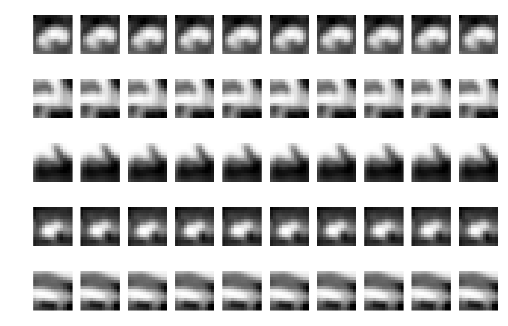

(5, 10, 13, 13)

In [8]:
def print_outputs(lay=[3,4,5,6,7]):
    nn.get_output(train[0][:5])
    for l in lay:
        imshow(nn[l].output)
# print_outputs()  

nn.get_output(train[0][:5])
imshow(nn[5].output)

In [7]:
np.set_printoptions(threshold=np)
nn.get_output(train[0][:3])

array([[ 0.08,  0.19,  0.11,  0.12,  0.1 ,  0.06,  0.06,  0.1 ,  0.07,
         0.11],
       [ 0.08,  0.19,  0.11,  0.12,  0.1 ,  0.06,  0.06,  0.1 ,  0.07,
         0.11],
       [ 0.08,  0.19,  0.11,  0.12,  0.1 ,  0.06,  0.06,  0.1 ,  0.07,
         0.11]])

Training network: newtest1-2conv-3abstract-layer500-300-10
   batch: 5 of 5  --- Epoch:  1   Mean loss:  2.2961217651
   batch: 5 of 5  --- Epoch:  2   Mean loss:  2.27875956205
   batch: 5 of 5  --- Epoch:  3   Mean loss:  2.2719582996
   batch: 5 of 5  --- Epoch:  4   Mean loss:  2.26902948
   batch: 5 of 5  --- Epoch:  5   Mean loss:  2.26759091364
   batch: 5 of 5  --- Epoch:  6   Mean loss:  2.26674734313
   batch: 5 of 5  --- Epoch:  7   Mean loss:  2.26614246096
   batch: 5 of 5  --- Epoch:  8   Mean loss:  2.26562945084
   batch: 5 of 5  --- Epoch:  9   Mean loss:  2.265147611
   batch: 5 of 5  --- Epoch:  10   Mean loss:  2.26467277821
   batch: 5 of 5  --- Epoch:  11   Mean loss:  2.26419641904
   batch: 5 of 5  --- Epoch:  12   Mean loss:  2.26371654403
   batch: 5 of 5  --- Epoch:  13   Mean loss:  2.26323371967
   batch: 5 of 5  --- Epoch:  14   Mean loss:  2.2627493338
   batch: 5 of 5  --- Epoch:  15   Mean loss:  2.26226487523
   batch: 5 of 5  --- Epoch:  16   Mean los

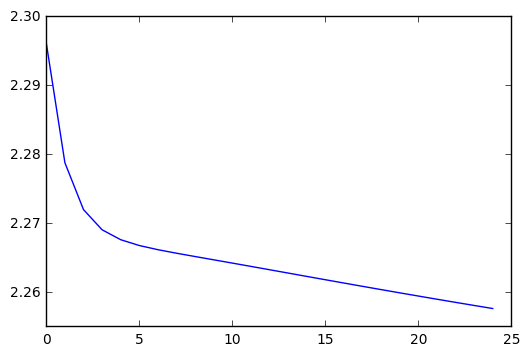

Saving network snapshot to newtest1-2conv-3abstract-layer500-300-10.net


In [6]:
train_net()

Training network: newtest1-2conv-3abstract-layer500-300-10
   batch: 50 of 50  --- Epoch:  1   Mean loss:  2.37773550762
   batch: 50 of 50  --- Epoch:  2   Mean loss:  2.36626002161
   batch: 50 of 50  --- Epoch:  3   Mean loss:  2.36550006123
   batch: 50 of 50  --- Epoch:  4   Mean loss:  2.36489011701
   batch: 50 of 50  --- Epoch:  5   Mean loss:  2.3644410387
   batch: 50 of 50  --- Epoch:  6   Mean loss:  2.36415786978
   batch: 50 of 50  --- Epoch:  7   Mean loss:  2.3640471988
   batch: 50 of 50  --- Epoch:  8   Mean loss:  2.36411752595
   batch: 50 of 50  --- Epoch:  9   Mean loss:  2.36438037728
   batch: 50 of 50  --- Epoch:  10   Mean loss:  2.3648507695
   batch: 50 of 50  --- Epoch:  11   Mean loss:  2.36554774726
   batch: 50 of 50  --- Epoch:  12   Mean loss:  2.36649656202
   batch: 50 of 50  --- Epoch:  13   Mean loss:  2.36773292137
   batch: 50 of 50  --- Epoch:  14   Mean loss:  2.3693092457
   batch: 50 of 50  --- Epoch:  15   Mean loss:  2.37131552246
   batch:

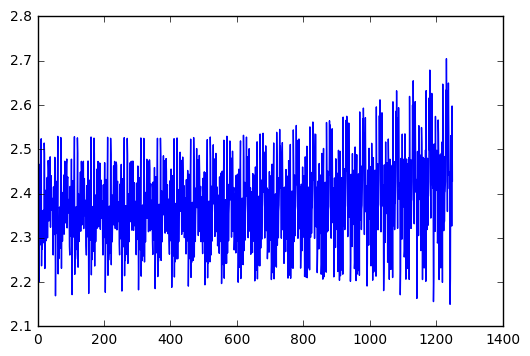

Saving network snapshot to newtest1-2conv-3abstract-layer500-300-10.net


In [43]:
train_net()

In [13]:
for l in nn:
    print l.delta.shape

(20, 3, 32, 32)
(20, 3, 30, 30)
(1, 3, 15, 15)
(1, 3, 15, 15)
(1, 3, 15, 15)
(1, 3, 13, 13)
(1, 3, 13, 13)
(1, 3, 13, 13)
(1, 507)
(1, 300)
(1, 300)
(1, 10)


AttributeError: output instance has no attribute 'delta'

In [7]:
act = nn[8]

In [8]:
old_input = act.prev.output
act.input = old_input
old_delta = act.backprop_delta(act.delta)

mean_input = act.input.mean(axis=0)
act.input = mean_input
curr_delta = act.backprop_delta(act.delta)

print old_delta.shape, curr_delta.shape
print np.all(old_delta.mean(axis=0) == curr_delta)

(20, 300) (1, 300)
False


In [65]:
np.count_nonzero(nn[6].delta)

10140

In [10]:
nn[4].output.mean()

0.49999999999999933

In [2]:
nn[1].kernels[0,0]
imshow(np.sum(nn[1].output[1,:3], axis=0))
imshow(nn[1].output[1,0])

AttributeError: Conv instance has no attribute 'output'

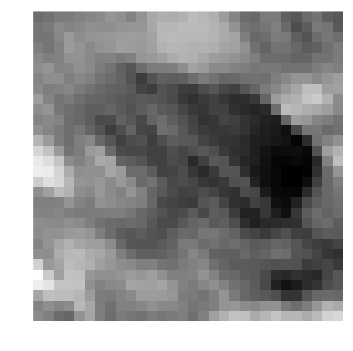

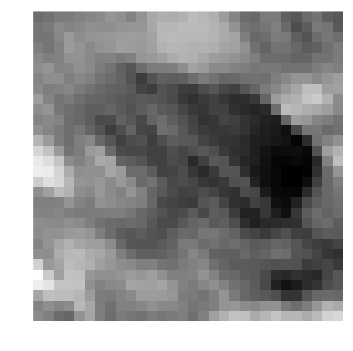

(30, 30)

In [4]:
nn[1].kernels[0,0]
imshow(np.sum(nn[1].output[1,:3], axis=0))
imshow(nn[1].output[1,0])

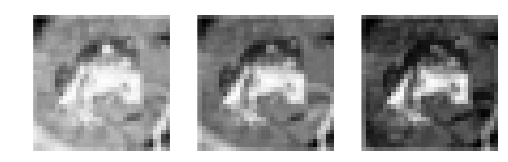

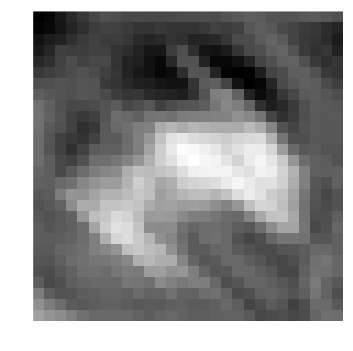

(28, 28)

In [8]:
nn[1].kernels[0,0]
imshow(nn[0].output[0,:3])
imshow(nn[1].output[0,0])

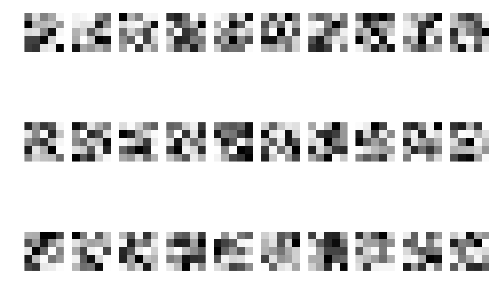

(3, 10, 5, 5)

In [23]:
imshow(nn[1].kernels)

In [30]:
for k in nn[1].kernels[0]: print k

[[ 0.3   0.34 ...,  0.17  0.21]
 [ 0.62  0.37 ...,  0.82  0.73]
 ..., 
 [ 0.72  0.44 ...,  0.4   0.39]
 [ 0.61  0.64 ...,  0.68  0.14]]
[[ 0.37  0.62 ...,  0.37  0.22]
 [ 0.57  0.56 ...,  0.6   0.19]
 ..., 
 [ 0.94  0.8  ...,  0.81  0.55]
 [ 0.87  0.06 ...,  0.55  0.25]]
[[ 0.93  0.57 ...,  0.22  0.3 ]
 [ 0.75  0.88 ...,  0.34  0.8 ]
 ..., 
 [ 0.04  0.65 ...,  0.83  0.85]
 [ 0.69  0.24 ...,  0.71  0.3 ]]
[[ 0.4   0.19 ...,  0.79  0.49]
 [ 0.17  0.51 ...,  0.18  0.39]
 ..., 
 [ 0.97  0.48 ...,  0.7   0.27]
 [ 0.78  0.93 ...,  0.46  0.13]]
[[ 0.98  0.24 ...,  1.    0.58]
 [ 0.2   0.9  ...,  0.03  0.23]
 ..., 
 [ 0.74  0.26 ...,  0.29  0.62]
 [ 0.98  0.24 ...,  0.51  0.31]]
